## Multi-Class Image Classification

In [1]:
from fastai.vision.all import *

In [24]:
from fastbook import *

### Loading the Data

In [2]:
# download data
path = untar_data(URLs.PETS)

In [3]:
# set base path
Path.BASE_PATH = path

In [4]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [5]:
(path/"images").ls()

(#7393) [Path('images/Ragdoll_197.jpg'),Path('images/newfoundland_36.jpg'),Path('images/boxer_107.jpg'),Path('images/scottish_terrier_5.jpg'),Path('images/yorkshire_terrier_136.jpg'),Path('images/keeshond_21.jpg'),Path('images/beagle_188.jpg'),Path('images/chihuahua_139.jpg'),Path('images/basset_hound_44.jpg'),Path('images/Russian_Blue_135.jpg')...]

In [6]:
file_name = (path/"images").ls()[0]
file_name

Path('images/Ragdoll_197.jpg')

In [7]:
re.findall(r'(.+)_\d+.jpg$', file_name.name)

['Ragdoll']

In [8]:
using_attr(print, 'name')(file_name)

Ragdoll_197.jpg


In [9]:
# creating a datablock from files
pets_block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       splitter=RandomSplitter(seed=42),
                       get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                       item_tfms=Resize(460),
                       batch_tfms=aug_transforms(size=224, min_scale=.75))
data_loaders = pets_block.dataloaders(path/"images")

### Verify the Data

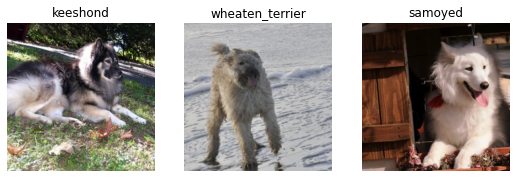

In [10]:
data_loaders.show_batch(nrows=1, ncols=3)

In [11]:
# display a summary of our datablock
pets_block.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /storage/data/oxford-iiit-pet/images/english_setter_53.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x400
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /storage/data/oxford-iiit-pet/images/english_setter_53.jpg
    applying partial gives
      english_setter
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(19)

Final sample: (PILImage mode=RGB size=500x400, TensorCategory(19))


Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting 

### Train a Simple Model to Verify the Data

In [12]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
learn = cnn_learner(data_loaders, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.498044,0.306780,0.107578,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.503090,0.281477,0.089986,00:32
1,0.320499,0.199525,0.064953,00:33


### Cross-Entropy Loss

In [14]:
# get some data from the data loader
x, y = data_loaders.one_batch()

In [15]:
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [16]:
# inspect some predictions
preds, _ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.1682e-07, 2.7087e-06, 3.1473e-06, 6.2178e-07, 1.6329e-07, 7.6003e-07,
        1.4346e-06, 4.8588e-07, 2.5022e-06, 5.8645e-08, 1.7783e-07, 7.6690e-08,
        2.6402e-04, 1.1704e-05, 6.8449e-06, 1.3167e-05, 7.8117e-05, 2.5666e-08,
        5.0653e-06, 1.2874e-04, 6.4425e-06, 9.5722e-06, 1.7589e-05, 1.9453e-05,
        8.3504e-07, 5.8358e-05, 2.2916e-07, 7.3010e-06, 2.3480e-07, 6.3814e-07,
        9.9935e-01, 3.3047e-06, 7.1987e-07, 2.7813e-06, 9.9715e-07, 1.1827e-06,
        7.1062e-07])

In [17]:
# the learner defaulted to cross-entropy therefore it sums to 1
len(preds[0]), preds[0].sum()

(37, tensor(1.))

#### Softmax

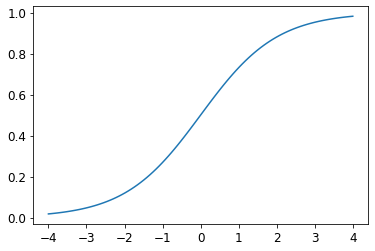

In [26]:
# remember what the sigmoid looks
plot_function(torch.sigmoid, min=-4, max=4)

In [27]:
# generate random data
torch.random.manual_seed(42)

random_numbers = torch.randn((6,2))*2
random_numbers

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [28]:
random_numbers.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [29]:
# now we take the relative difference as relative confidence
(random_numbers[:, 0]-random_numbers[:, 1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [30]:
# now we need a way to do this with more classes - welcome softmax

$Softmax(x) = \frac{e_x}{\sum{e^x}}$

In [31]:
sm_numbers = torch.softmax(random_numbers, dim=1)
sm_numbers

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

#### Log Likelihood

In [32]:
# suppose our targets are
targets = tensor([0,1,1,0,1,0])

In [33]:
# and our softmax output is
sm_numbers

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [34]:
# so we can pick our class probability like this
sm_numbers[range(6), targets]

tensor([0.6025, 0.4979, 0.8668, 0.9966, 0.4041, 0.3661])

In [35]:
# not for the loss, lower is better so...
-sm_numbers[range(6), targets]

tensor([-0.6025, -0.4979, -0.8668, -0.9966, -0.4041, -0.3661])

In [36]:
# which is the same as the negative log likelihood
F.nll_loss(sm_numbers, targets, reduction='none')

tensor([-0.6025, -0.4979, -0.8668, -0.9966, -0.4041, -0.3661])

#### Taking the Log

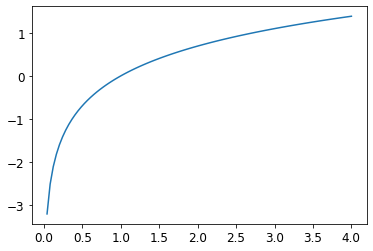

In [37]:
# now we want a bounded output - thats what log is for
plot_function(torch.log, min=0, max=4)

In [38]:
# now we really want to do this with more classes - otherwise we could use sigmoid
random_numbers = torch.randn((4,3))*2
targets = tensor([1, 0, 1, 2])

In [39]:
# our predictions and targets
random_numbers, targets

(tensor([[ 2.2206, -3.3796, -1.9779],
         [ 1.9159,  2.6443,  1.6344],
         [-1.5317, -1.5012,  2.7051],
         [ 1.3726, -0.6555,  1.5899]]),
 tensor([1, 0, 1, 2]))

*Cross entropy = (softmax + log_likelihood)*

In [40]:
# manual steps
sm_numbers = torch.log_softmax(random_numbers, dim=1)
negative_log_loss = F.nll_loss(sm_numbers, targets, reduction='none')
negative_log_loss.mean()

tensor(2.9608)

In [41]:
# or with functional interface or pytorch class
F.cross_entropy(random_numbers, targets), \
nn.CrossEntropyLoss()(random_numbers, targets)

(tensor(2.9608), tensor(2.9608))

Once again all the steps

In [42]:
# taking the softmax to sum to 1
sm_numbers = torch.log_softmax(random_numbers, dim=1)
sm_numbers

tensor([[-0.0185, -5.6187, -4.2170],
        [-1.3419, -0.6135, -1.6234],
        [-4.2657, -4.2353, -0.0289],
        [-0.8647, -2.8929, -0.6474]])

In [43]:
# (or taking the log separately)
sm_numbers = torch.softmax(random_numbers, dim=1)
sm_numbers = sm_numbers.log()
sm_numbers

tensor([[-0.0185, -5.6187, -4.2170],
        [-1.3419, -0.6135, -1.6234],
        [-4.2657, -4.2353, -0.0289],
        [-0.8647, -2.8929, -0.6474]])

In [44]:
# taking the negative log loss (which does not actually take the log 
# but assumes you have done it before)
negative_log_loss = F.nll_loss(sm_numbers, targets, reduction='none')
negative_log_loss

tensor([5.6187, 1.3419, 4.2353, 0.6474])

In [45]:
# taking the mean
negative_log_loss.mean()

tensor(2.9608)

### Model Interpretation

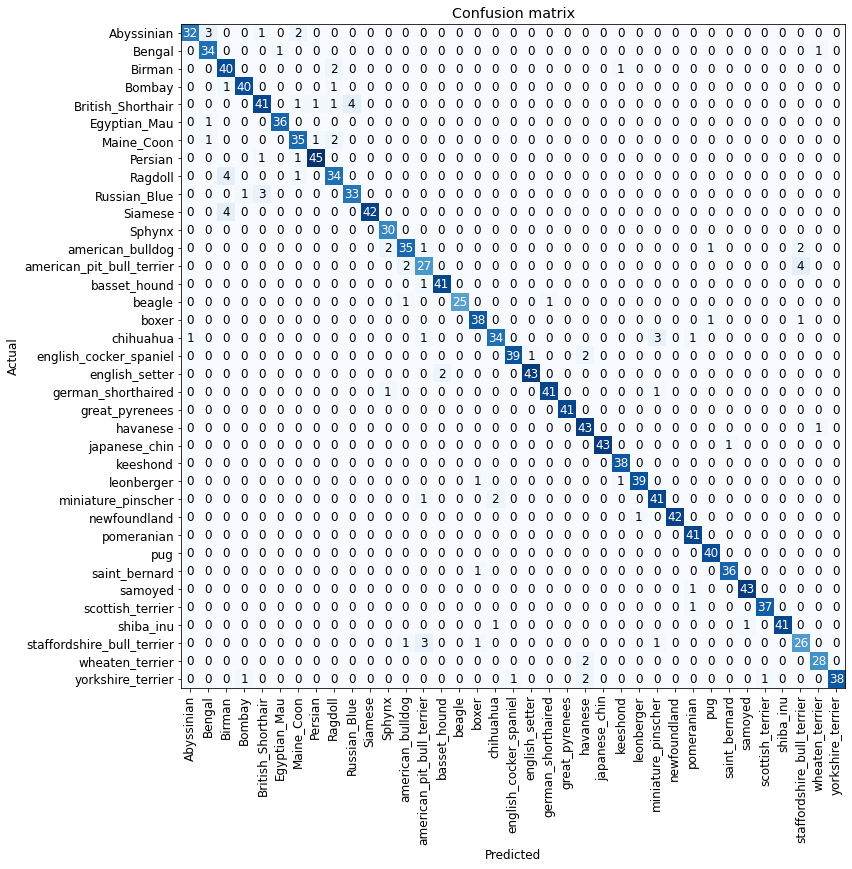

In [52]:
# try a confusion matrix
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix(figsize=(12,12))

In [54]:
# more helpful - plot the most confusing ones
interpretation.most_confused(min_val=3)

[('British_Shorthair', 'Russian_Blue', 4),
 ('Ragdoll', 'Birman', 4),
 ('Siamese', 'Birman', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('Abyssinian', 'Bengal', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3)]

### Improving Our Model

#### How to Find the Learning Rate - The Learning Rate Finder 

In [60]:
# inspect loss and metric from last training
learn.recorder.final_record

(#2) [0.19952484965324402,0.06495264172554016]

In [62]:
# increase the learning rate and see the result
learn = cnn_learner(data_loaders, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.815053,4.701339,0.443843,00:32


epoch,train_loss,valid_loss,error_rate,time
0,3.360482,1.718805,0.529770,00:41


We did cleary overshoot - lets make this more methodically.

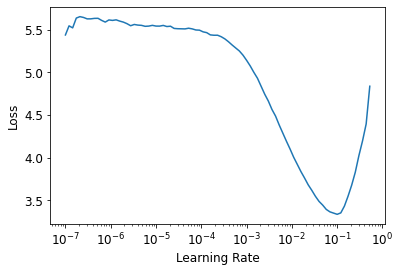

In [63]:
# use the learning rate finder (by leslie smith)
learn = cnn_learner(data_loaders, resnet34, metrics=error_rate)
lr_min, lr_steep = learn.lr_find()

In [64]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 4.37e-03


In [68]:
# try a more suiting learning rate
learn = cnn_learner(data_loaders, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.304966,0.292407,0.100135,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.541636,0.390620,0.119756,00:41
1,0.346177,0.227515,0.075778,00:41


The error rate is decreasing so that seems to be going in the right direction.

#### Unfreezing and Transfer Learning

In [70]:
# we can also to the fine_tuning ourselfes
learn = cnn_learner(data_loaders, resnet34, metrics=error_rate)

# 1. training the head for 3 epochs (remember our network is already freezed)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.114381,0.335116,0.108254,00:32
1,0.547629,0.225818,0.073072,00:33
2,0.342043,0.202872,0.067659,00:32


In [71]:
# unfreeze the complete model
learn.unfreeze()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=7.585775847473997e-07)

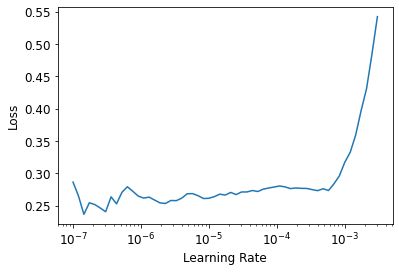

In [72]:
# now with all layer unfreezed we need to re-find our learning rate
learn.lr_find()

In [73]:
# we pick a learning rate BEFORE it starts to increase 
learn.fit_one_cycle(6, lr_max=4e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.266734,0.186616,0.060893,00:41
1,0.239120,0.208222,0.062923,00:41
2,0.183959,0.194899,0.060217,00:41
3,0.161252,0.161248,0.050068,00:41
4,0.124450,0.166828,0.053451,00:41
5,0.111791,0.161350,0.050744,00:41


#### Discriminative Learning Rates

In [77]:
# this time we only set the lowest layer of our network to the rate 
learn = cnn_learner(data_loaders, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.119269,0.323647,0.098106,00:32
1,0.547703,0.251516,0.088633,00:33
2,0.326897,0.199743,0.063599,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.258293,0.197729,0.064953,00:41
1,0.254044,0.189900,0.064953,00:41
2,0.240262,0.186445,0.059540,00:42
3,0.214846,0.183870,0.063599,00:41
4,0.197889,0.175031,0.057510,00:41
5,0.181002,0.172325,0.056157,00:41
6,0.168709,0.172491,0.056834,00:41
7,0.147173,0.171180,0.056834,00:42
8,0.130008,0.171994,0.054804,00:41
9,0.137078,0.175226,0.060217,00:41


In [79]:
# the loss is decreasing till the end so we make the learning rate a little higher 
learn = cnn_learner(data_loaders, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.182307,0.305878,0.093369,00:32
1,0.531587,0.235868,0.079161,00:33
2,0.333572,0.197204,0.061570,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.270774,0.190727,0.064953,00:41
1,0.255724,0.189878,0.066982,00:41
2,0.228695,0.187896,0.064953,00:41
3,0.198091,0.173788,0.061570,00:41
4,0.177936,0.181137,0.060893,00:42
5,0.147602,0.182835,0.060893,00:41
6,0.125672,0.175280,0.059540,00:41
7,0.104862,0.173641,0.056834,00:41
8,0.097041,0.164205,0.062923,00:41
9,0.099604,0.167073,0.055480,00:41


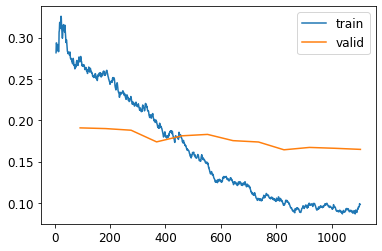

In [80]:
# print the loss
learn.recorder.plot_loss()

The training loss keeps getting better but the validation loss ultimatively slows down. Thats a sign of overfitting - which does not mean that is is getting less accurate. But how long shall we train?

#### Selecting the Number of Epochs

#### Deeper Architectures

In [82]:
# try a deeper network
learn = cnn_learner(data_loaders, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(10, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,1.412719,0.300957,0.100812,00:43
1,0.605045,0.294118,0.094723,00:44
2,0.431313,0.262558,0.083897,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.257092,0.213887,0.071719,00:56
1,0.220372,0.274191,0.079838,00:56
2,0.281550,0.343154,0.093369,00:56
3,0.218873,0.374652,0.100135,00:56
4,0.170669,0.286821,0.076455,00:56
5,0.109297,0.257928,0.071042,00:56
6,0.083950,0.264730,0.063599,00:56
7,0.049029,0.226116,0.063599,00:56
8,0.031923,0.197835,0.057510,00:56
9,0.027789,0.198639,0.058187,00:56


A bigger network is not always better - though we had better results when training it for less epochs.

In [84]:
# try a deeper network
learn = cnn_learner(data_loaders, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(12, freeze_epochs=4)

epoch,train_loss,valid_loss,error_rate,time
0,1.527847,0.304262,0.101489,00:43
1,0.647056,0.261307,0.085250,00:44
2,0.461801,0.244933,0.080514,00:44
3,0.377674,0.266427,0.079838,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.240433,0.187990,0.056157,00:56
1,0.189720,0.321680,0.089986,00:56
2,0.245693,0.317055,0.089986,00:56
3,0.220661,0.292494,0.083897,00:56
4,0.179985,0.300213,0.085250,00:56
5,0.147370,0.331008,0.088633,00:56
6,0.112051,0.262489,0.080514,00:56
7,0.076217,0.237750,0.068336,00:56
8,0.049482,0.217862,0.058863,00:56
9,0.032698,0.209718,0.056834,00:56


Its seems that the freezing leads to overfitting and later need to relearn. Lets try with less freeze.

In [85]:
# try a deeper network
learn = cnn_learner(data_loaders, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(12, freeze_epochs=2)

epoch,train_loss,valid_loss,error_rate,time
0,1.269551,0.281975,0.092693,00:43
1,0.573905,0.294059,0.097429,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.288242,0.238298,0.073748,00:56
1,0.243701,0.247382,0.073072,00:56
2,0.273928,0.337553,0.100135,00:56
3,0.251821,0.357385,0.092016,00:56
4,0.215506,0.330522,0.092016,00:56
5,0.141613,0.285903,0.071042,00:56
6,0.097899,0.263010,0.073748,00:56
7,0.086661,0.251015,0.069689,00:56
8,0.049786,0.206147,0.061570,00:56
9,0.030636,0.198613,0.060217,00:56
